This notebook shows some basic statistics about the data.

In [7]:
%matplotlib inline
import sys,os
util_path = os.path.abspath(os.path.join(os.path.pardir, 'lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import argparse, logging, json
import datetime as dt
from datetime import timedelta

import itertools
from collections import OrderedDict

import math
import numpy as np
import pandas as pd

from lib.io import IO
from lib.bqhandler import BQHandler
from lib.viz import Viz

from geopy.distance import great_circle
from geopy.distance import geodesic

pd.set_option('display.width', 1000)

import seaborn as sns
sns.set()
sns.set(style="whitegrid", palette="muted")

In [3]:
bq = BQHandler()
io = IO(gs_bucket=options.gs_bucket)
viz = Viz(io=io)

In [4]:
class Options():
    pass
options = Options() 
options.starttime = '2010-01-01'
options.endtime = '2015-01-01'
#options.config_filename = 'cnf/rf.ini'
#options.config_name = '16_params_1'
options.stations_file = 'cnf/stations.json'
options.stations = None #'PSL,OL,TPE,OV,PM,II,KEM,HKI'
options.gs_bucket = 'trains-data'

options.project = 'trains-197305'
options.feature_dataset = 'trains_data'
options.feature_table = 'features'

options.label_params = ['delay']
options.feature_params = 'lat,lon,pressure,max_temperature,min_temperature,mean_temperature,mean_dewpoint,mean_humidity,mean_winddirection,mean_windspeedms,max_windgust,max_precipitation1h,max_snowdepth,max_n,min_vis,min_clhb,flashcount,max_precipitation3h,max_precipitation6h'.split(',')
options.meta_params = 'trainstation,time,train_type,train_count'.split(',')

# Get params
all_param_names = options.label_params + options.feature_params + options.meta_params
aggs = io.get_aggs_from_param_names(options.feature_params)
starttime, endtime = io.get_dates(options)

In [5]:
print('Loading data...')
all_data = bq.get_rows(starttime,
                       endtime,
                       loc_col='trainstation',
                       project=options.project,
                       dataset=options.feature_dataset,
                       table=options.feature_table,
                       parameters=all_param_names,
                       locations=None,
                       reason_code_table='reason_codes',
                       reason_codes_exclude=['T1','T2','P2','R1','R2','R3','R4','V4','K6','H1','H2','H3','M5','M4','S3']
)
print('Filtering data...')
all_data = io.filter_train_type(labels_df=all_data,
                            train_types=['K','L'],
                            sum_types=True,
                            train_type_column='train_type',
                            location_column='trainstation',
                            time_column='time',
                            sum_columns=['delay','train_count'],
                            aggs=aggs)

all_data.sort_values(by=['time', 'trainstation'], inplace=True)
all_data.set_index('time', inplace=True)
print('Data contain {} rows...'.format(len(all_data)))

Loading data...


/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:410: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Filtering data...
Data contain 10679977 rows...


In [6]:
avg_data = io.calc_delay_avg(all_data)

In [21]:
mean = avg_data.loc[:, 'delay'].mean()
print('Mean of average delay over whole dataset: {}'.format(mean))

Mean of average delay over whole dataset: 3.375953418071136


In [37]:
print('Loading data...')
weather_data = bq.get_rows(starttime,
                       endtime,
                       loc_col='trainstation',
                       project=options.project,
                       dataset=options.feature_dataset,
                       table=options.feature_table,
                       parameters=all_param_names,
                       locations=None,
                       reason_code_table='reason_codes',
                       reason_codes_include=['I2']
)
print('Filtering data...')
weather_data = io.filter_train_type(labels_df=weather_data,
                            train_types=['K','L'],
                            sum_types=True,
                            train_type_column='train_type',
                            location_column='trainstation',
                            time_column='time',
                            sum_columns=['delay','train_count'],
                            aggs=aggs)

weather_data.sort_values(by=['time', 'trainstation'], inplace=True)
weather_data.set_index('time', inplace=True)
print('Data contain {} rows...'.format(len(weather_data)))

Loading data...


/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:410: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Filtering data...
Data contain 7350 rows...


In [38]:
avg_weather_data = io.calc_delay_avg(weather_data)
mean_weather = avg_weather_data.loc[:, 'delay'].mean()
print('Mean of average delay over whole dataset: {}'.format(mean_weather))

Mean of average delay over whole dataset: 12.230969312475205


In [46]:
print(avg_data)

                          trainstation      delay  train_count        lat        lon  pressure  max_temperature  min_temperature  mean_temperature  mean_dewpoint     ...      max_windgust  max_precipitation1h  max_snowdepth  max_n  min_vis  min_clhb  flashcount  max_precipitation3h  max_precipitation6h  train_type
time                                                                                                                                                                  ...                                                                                                                                                  
2010-01-01 00:00:00+00:00          AHV   3.000000            1  61.291923  22.498185    1005.2            -11.1            -14.7             -12.4          -14.0     ...               9.2                  0.0           31.0    8.0   2140.0     300.0           0                  0.3                  0.7        None
2010-01-01 00:00:00+00:00          EPO   3.250000   

In [57]:
feb_2011 = avg_data.loc['2011-02-01':'2011-03-01',:].groupby('time').mean()

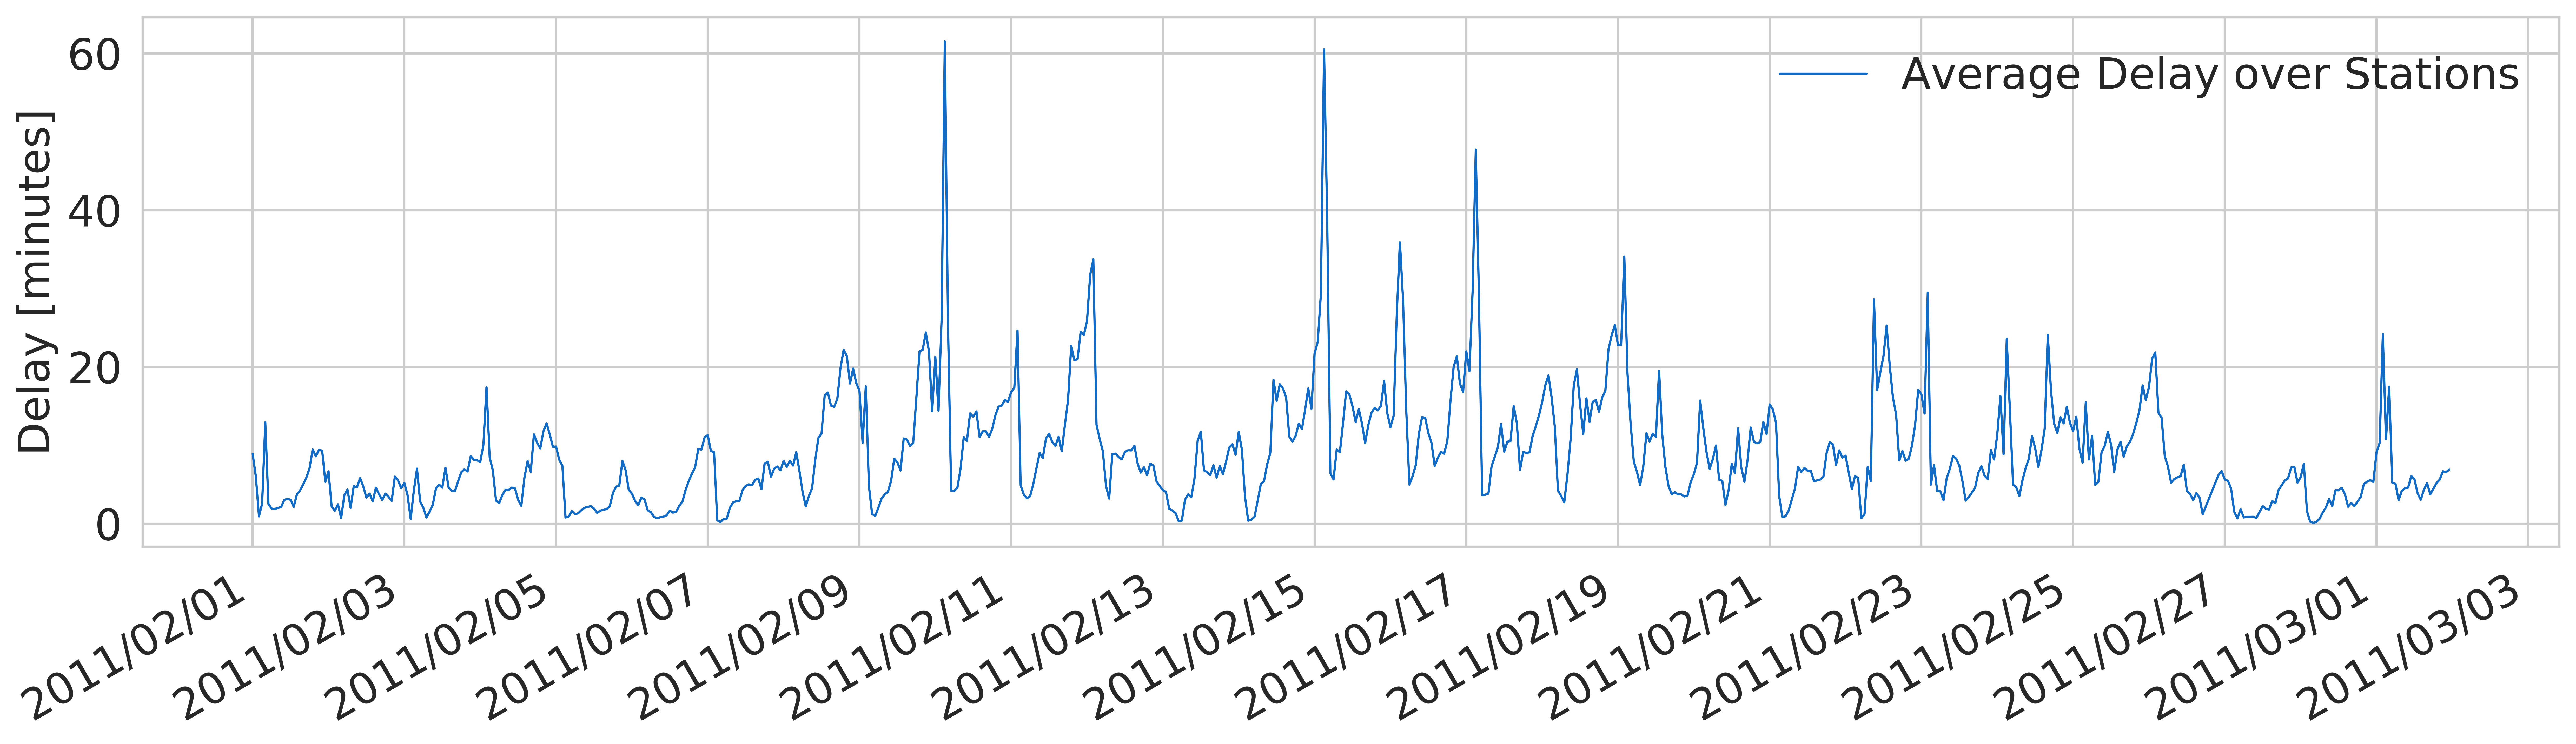

In [95]:
params = {'font.size': 40,
          'figure.dpi': 600,
          'date.autoformatter.day': '%Y/%m/%d',
          'date.autoformatter.month': '%Y/%m',
          'lines.color': 'r'}

plt.rcParams.update(params)

args = {'color': '#126cc5',
        'linewidth': 1,
        'figsize': (20,5),
        'label': 'Average Delay'}

ax = feb_2011.loc[:,['delay']].plot.line(**args)
ax.set_ylabel("Delay [minutes]", fontsize=20)
ax.set_xlabel("")
ax.legend(['Average Delay over Stations'], fontsize=20)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(labelsize=20)

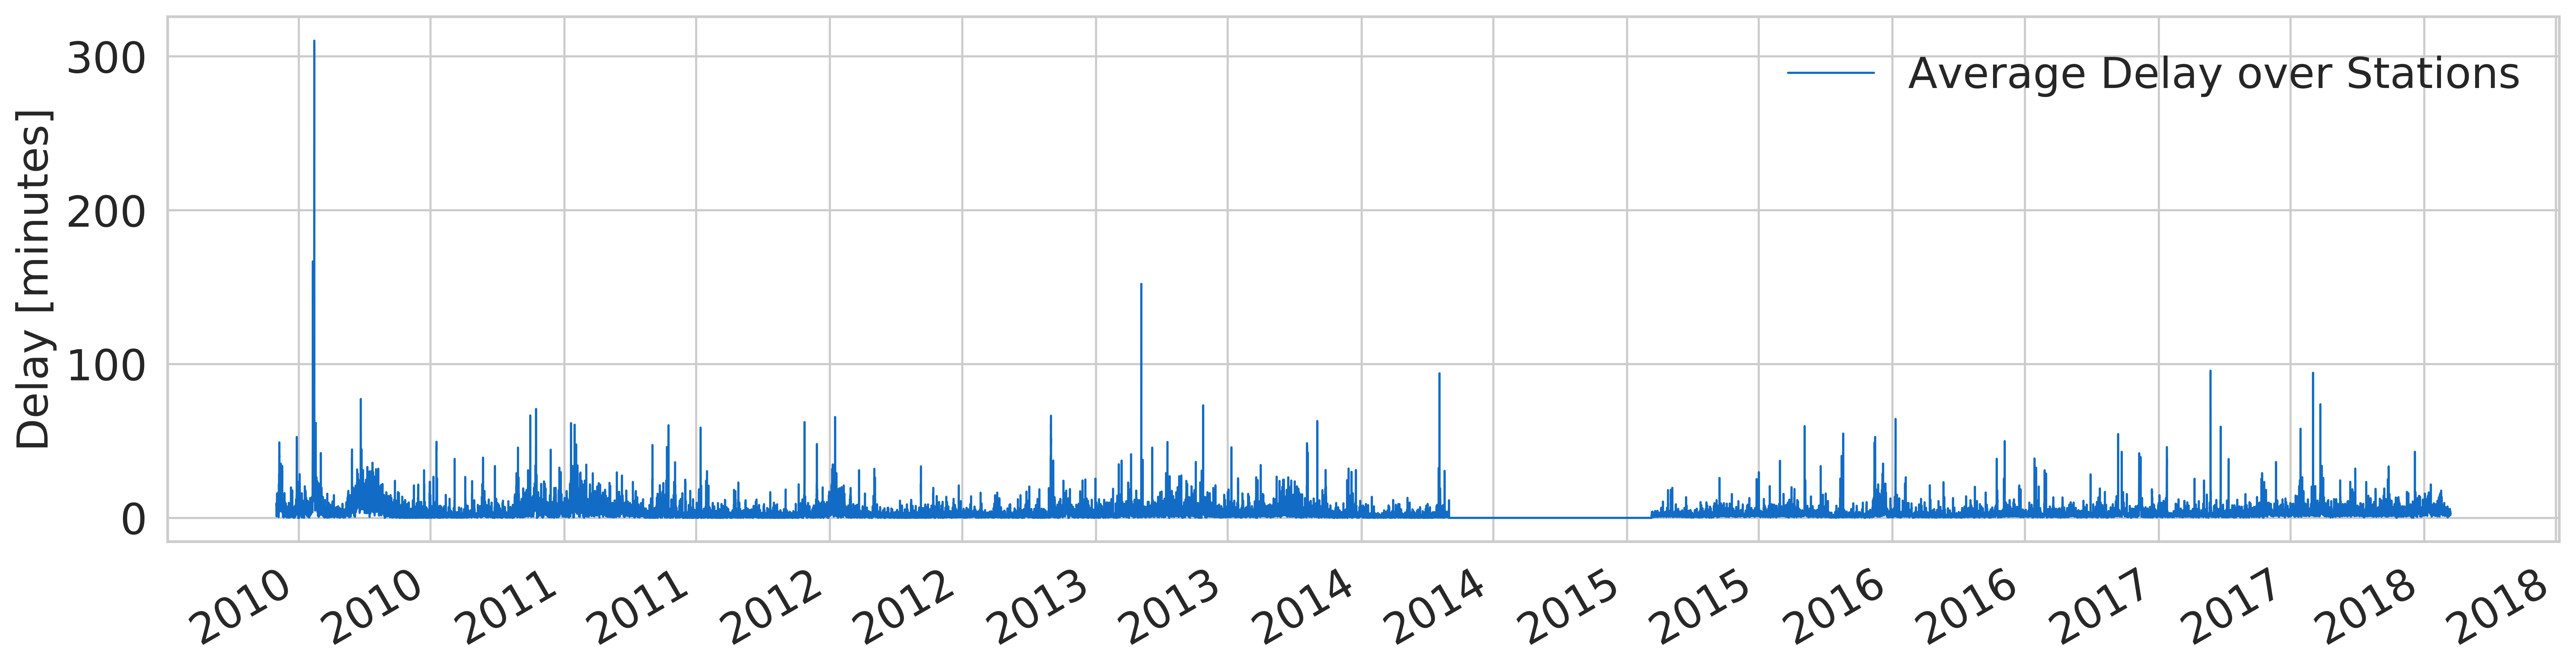

In [97]:
avg_avg_data = avg_data.groupby('time').mean()
ax = avg_avg_data.loc[:,['delay']].plot.line(**args)
ax.set_ylabel("Delay [minutes]", fontsize=20)
ax.set_xlabel("")
ax.legend(['Average Delay over Stations'], fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.tick_params(labelsize=20)

Pick features and labels and normalise

In [22]:
X = all_data.loc[:, options.feature_params].astype(np.float32).values
y = all_data.loc[:, 'delay'].astype(np.float32).values.ravel()

In [99]:
rfr_skill = pd.read_csv('skills.csv', sep=';', names=['sample_count', 'station', 'skill'])

In [100]:
print(rfr_skill)

     sample_count                  station   skill
0            1945              Espoo (EPO) -0.5718
1             302         Haapajärvi (HPJ) -0.4772
2             550         Haapakoski (HPS) -0.0797
3             459          Haapamäki (HPK) -0.4462
4            1542          Haarajoki (HAA) -0.1232
5            1682          Hakosilta (HLT) -0.2127
6             886        Hammaslahti (HSL) -0.0243
7            1385             Hanala (HNA)  0.0136
8             852         Hankasalmi (HKS)  0.0781
9             194        Hanko asema (HNK) -0.0495
10            547      Hanko tavara (HNKT)  0.1166
11            514    Hanko-Pohjoinen (HKP)  0.0737
12            695         Harjavalta (HVA) -0.0687
13            905               Harju (HJ)  0.0235
14           1137           Harviala (HRV) -0.0955
15            961          Haukipudas (HD) -0.0387
16            906         Haukivuori (HAU) -0.0176
17            907   Hausjärvi tavara (HAS)  0.0038
18            776           Hav

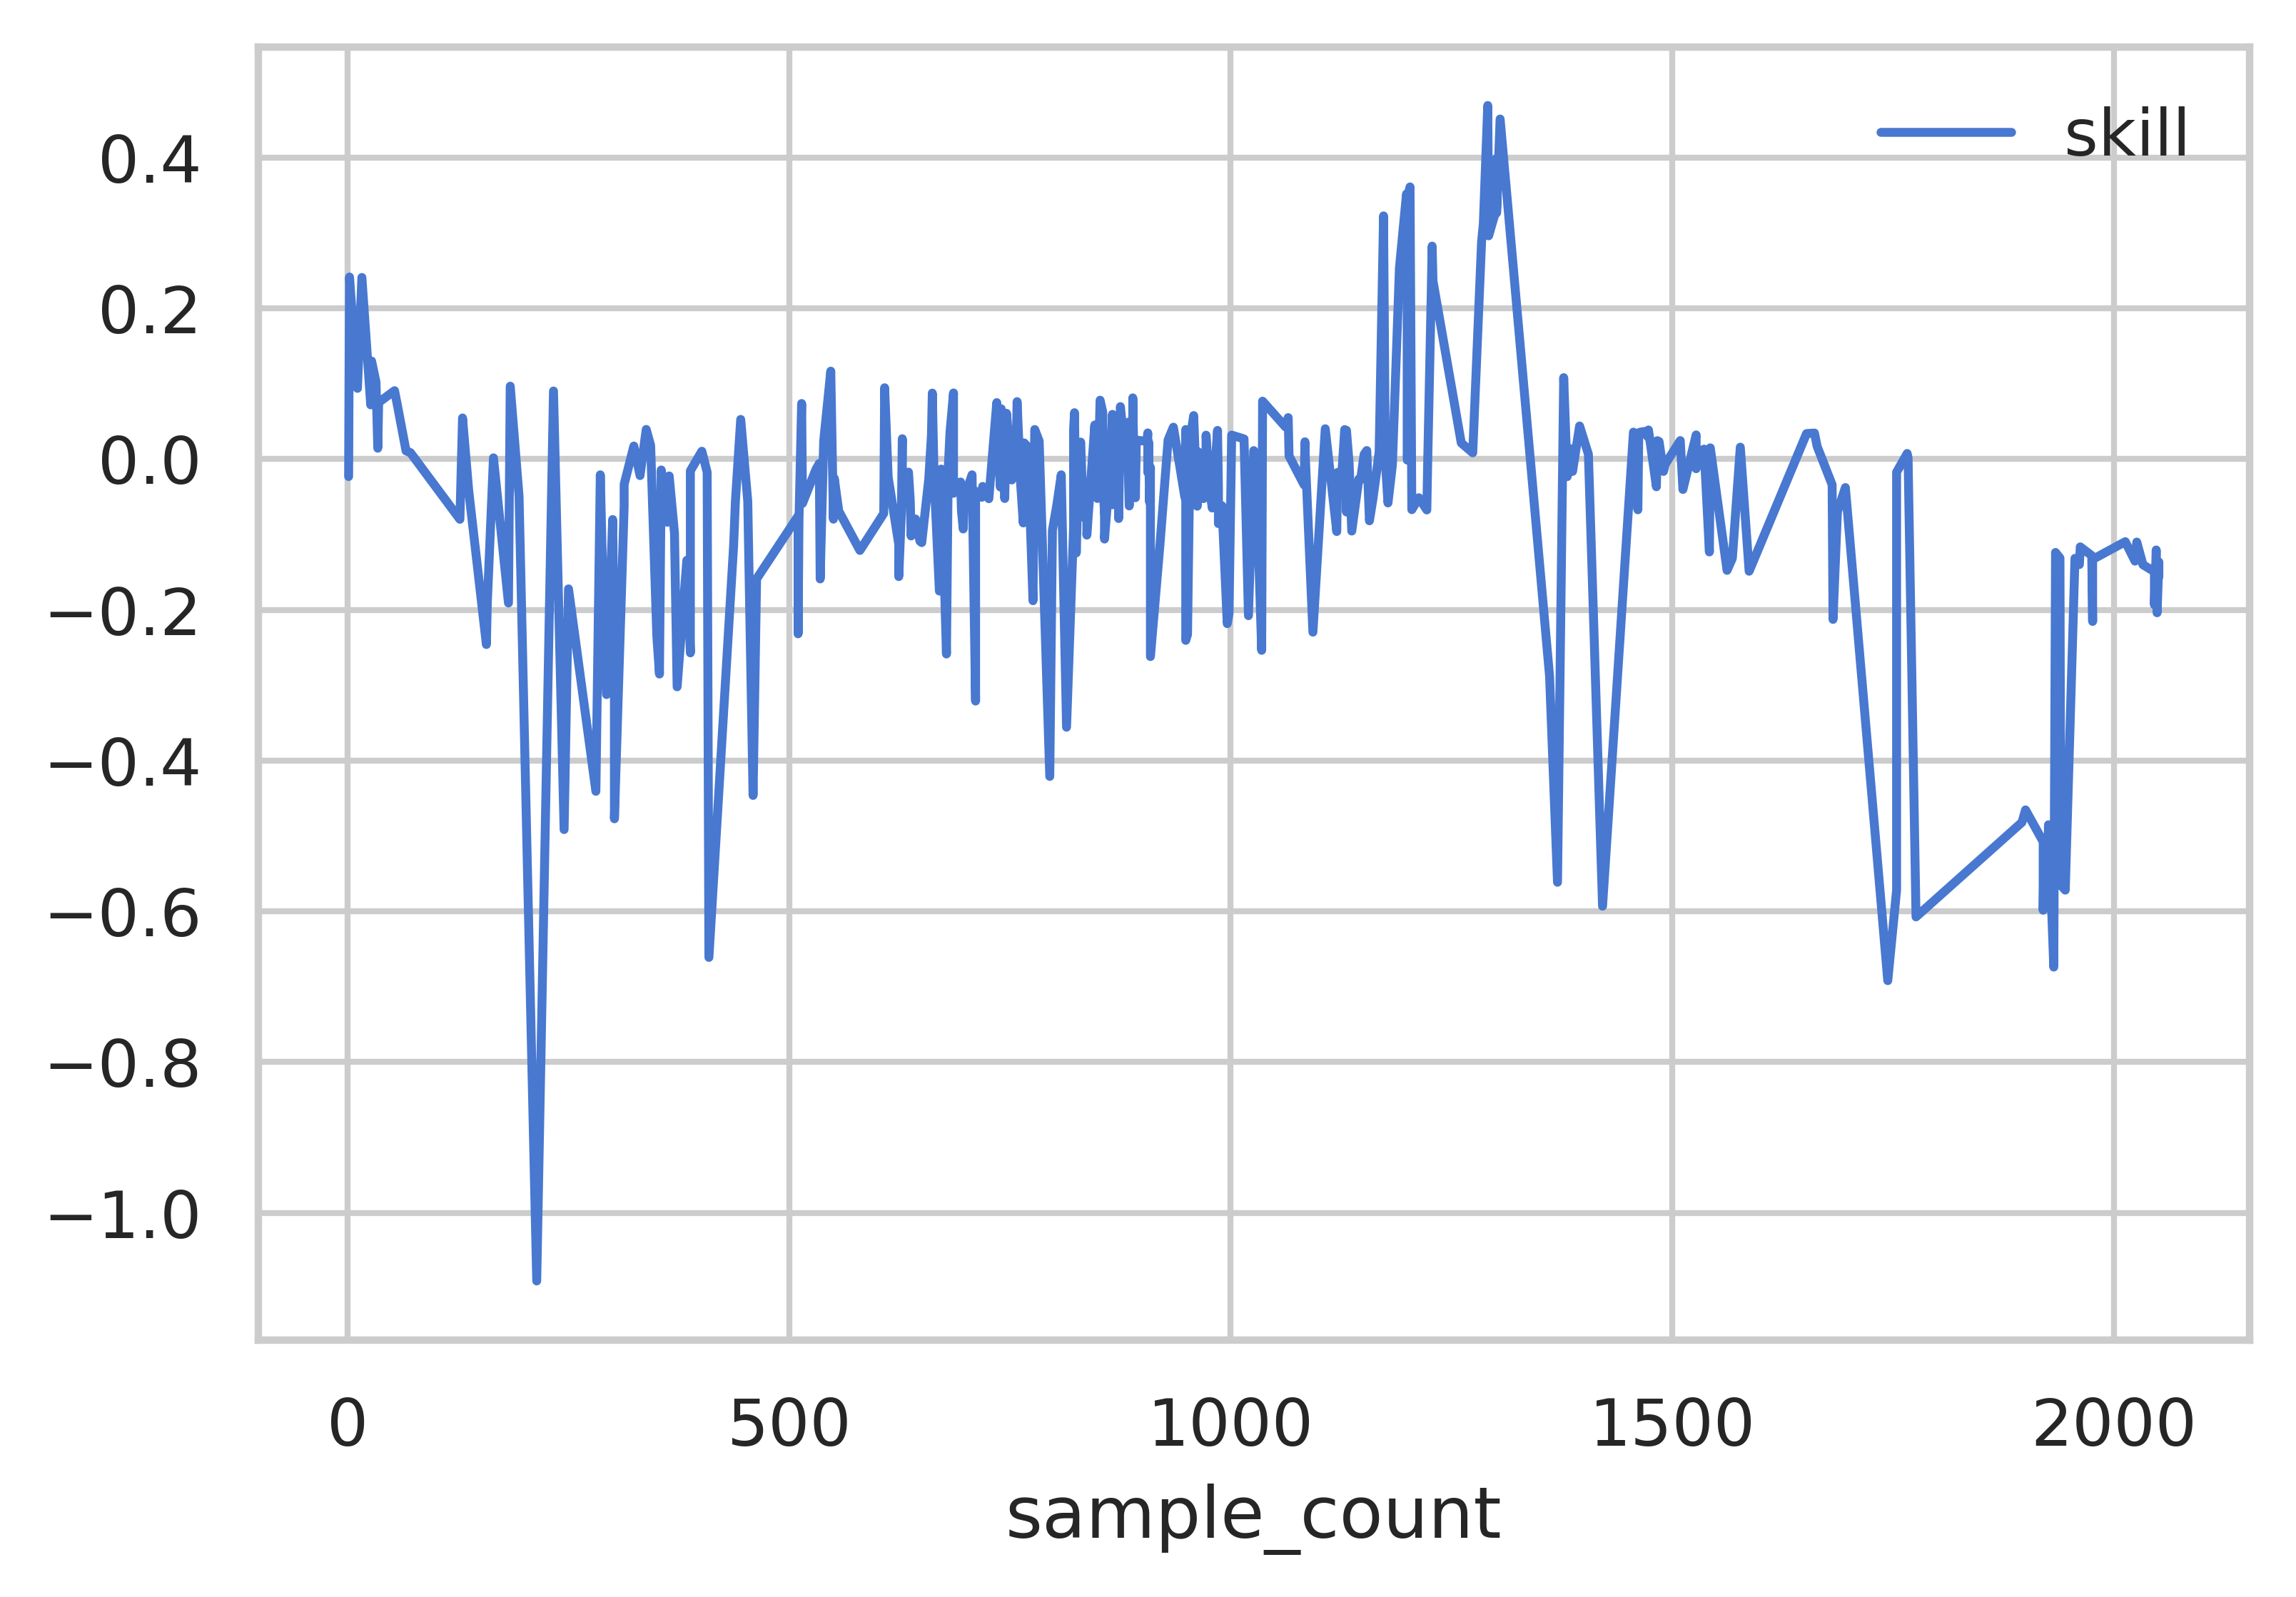

In [105]:
rfr_skill.sort_values(by='sample_count', inplace=True)
rfr_skill.plot(x='sample_count', y='skill')

In [110]:
from collections import defaultdict
from configparser import ConfigParser
from google.cloud import bigquery
import re

In [107]:
client = bigquery.Client()

In [122]:
def get_row_count(station):
    regex = r"(?<=\().*(?=\))"
    matches = re.search(regex, station, re.MULTILINE)
    sql = "SELECT COUNT(1) as c FROM `trains-197305.trains_data.features_testset` WHERE trainstation='{}'".format(matches[0])
    
    result = client.query(sql).result()
    return result.to_dataframe().loc[0,'c']

    
print(get_row_count('Ähtäri (ÄHT)'))

428


In [123]:
rfr_skill['train_samples'] = rfr_skill.apply(lambda x: get_row_count(x['station']), axis=1)

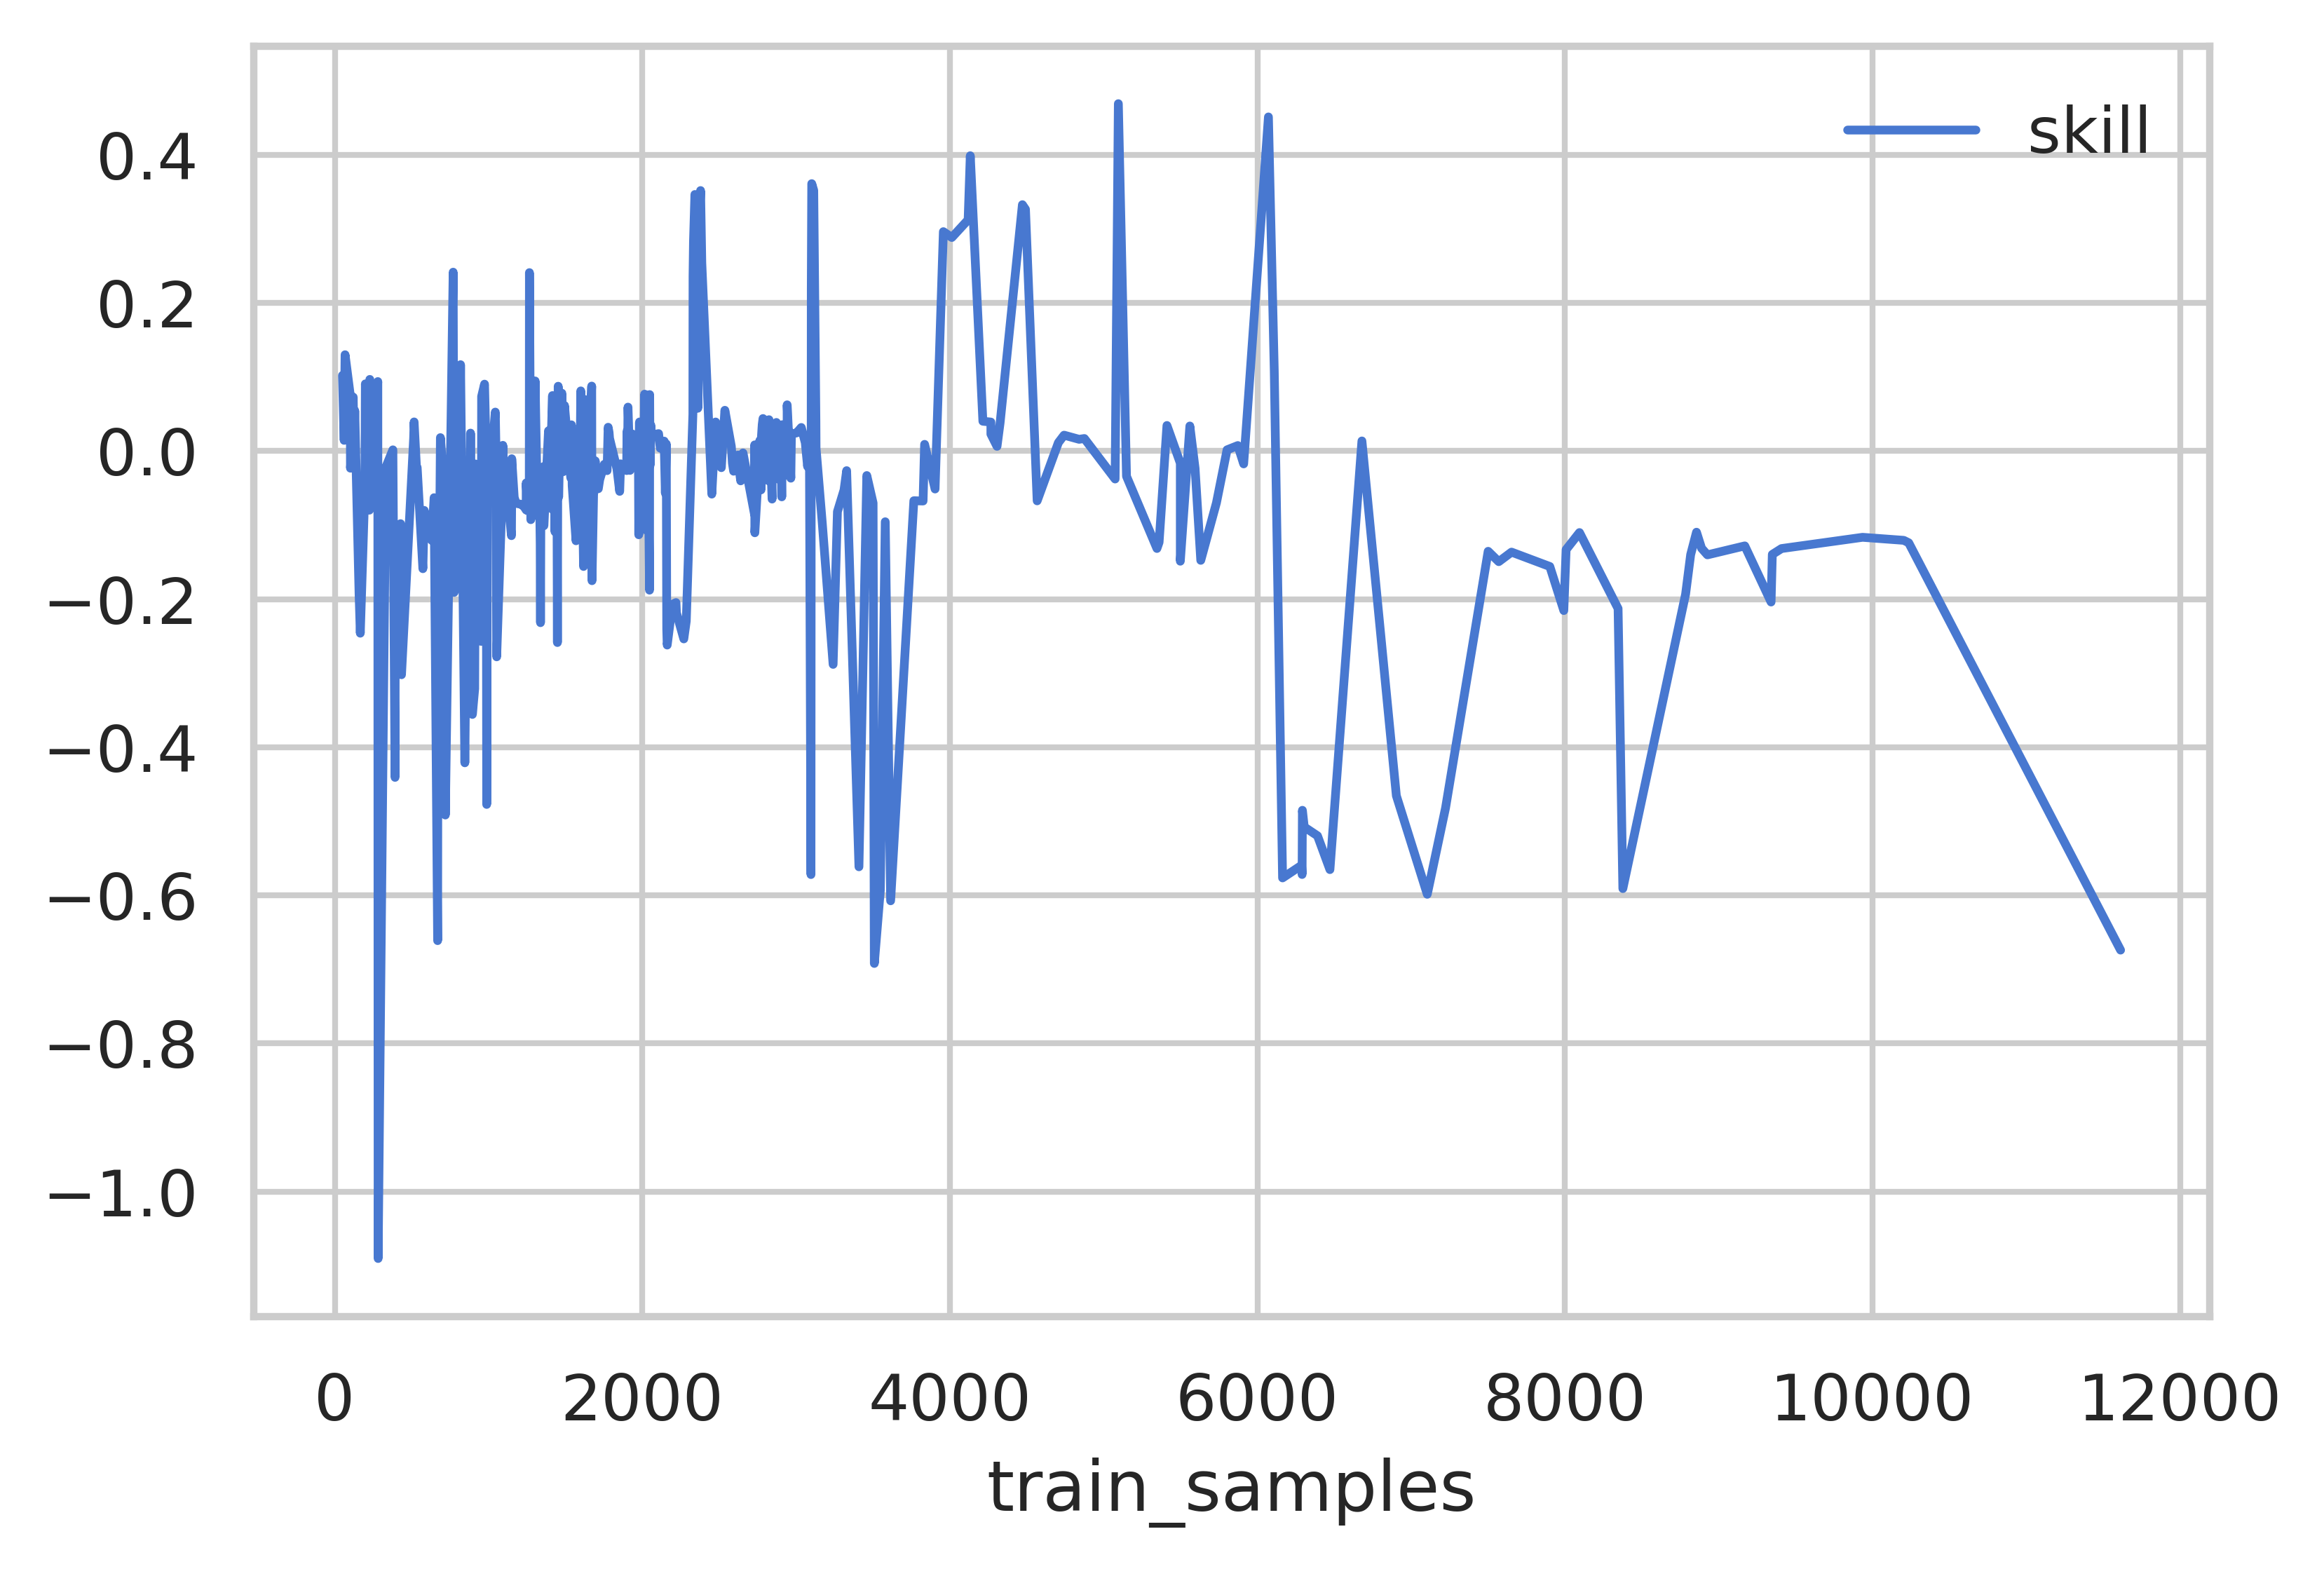

In [124]:
rfr_skill.sort_values(by='train_samples', inplace=True)
rfr_skill.plot(x='train_samples', y='skill')

In [125]:
print(rfr_skill.loc[:,'skill'].mean())

-0.057156851311953354


In [126]:
rf = io.load_scikit_model('models/rf/trains_data/all_params_avg_1/model.pkl')

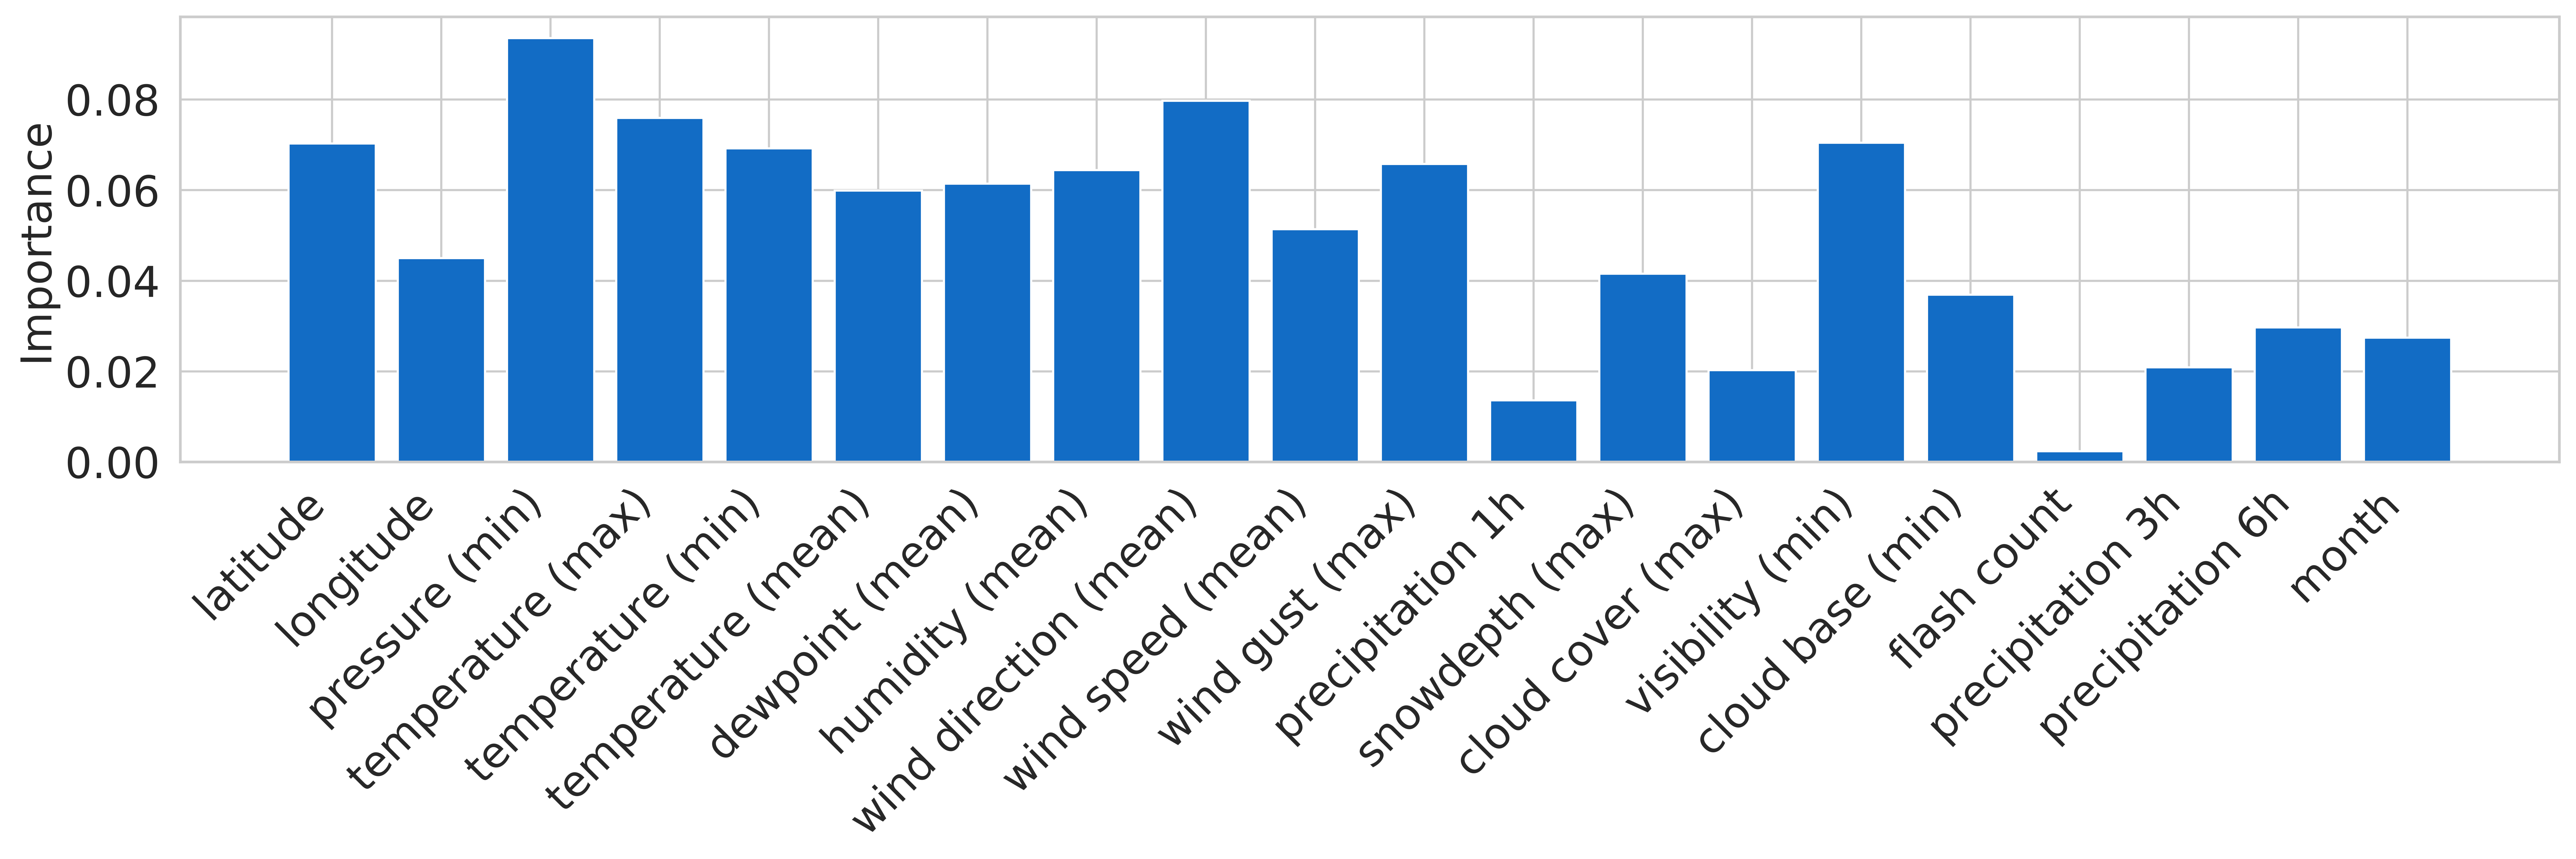

In [150]:
def rfc_feature_importance(data, feature_names):
        fig, ax = plt.subplots(figsize=(20,5))

        fontsize = 20
        plt.clf()

        plt.yticks(fontsize=fontsize)
        if feature_names is None:
            feature_names = range(0,len(data))
        else:
            plt.xticks(rotation=45, fontsize=fontsize, ha='right')
            fig.subplots_adjust(bottom=0.3)

        plt.bar(feature_names, data, align='center', color='#126cc5')
        plt.xlabel('')
        plt.ylabel('Importance', fontsize=fontsize)

labels = ['latitude', 'longitude', 'pressure (min)', 
          'temperature (max)', 'temperature (min)', 
          'temperature (mean)', 'dewpoint (mean)', 
          'humidity (mean)', 'wind direction (mean)', 
          'wind speed (mean)', 'wind gust (max)', 
          'precipitation 1h', 'snowdepth (max)', 
          'cloud cover (max)', 'visibility (min)',
          'cloud base (min)', 'flash count', 
          'precipitation 3h', 'precipitation 6h', 'month']

params = {'font.size': 40,
          'figure.dpi': 600,
          'date.autoformatter.day': '%Y/%m/%d',
          'date.autoformatter.month': '%Y/%m',
          'lines.color': 'r'}

plt.rcParams.update(params)

args = {'color': '#126cc5',
        'linewidth': 1,
        'figsize': (20,5),
        'label': 'Average Delay'}

rfc_feature_importance(rf.feature_importances_, labels)

In [151]:
print(rfr_skill[rfr_skill.loc[:,'skill'] > 0])

     sample_count                   station   skill  train_samples
107            32              Kolari (KLI)  0.1021             50
190            34           Niemenpää (NMP)  0.0144             61
86             27           Kemijärvi (KJÄ)  0.1300             67
336            35            Vuosaari (VSA)  0.0751            101
298            66      Tornio-Itäinen (TRI)  0.0109            115
42             26     Ilmala ratapiha (ILR)  0.0719            120
297            56        Tornio asema (TOR)  0.0728            120
80             71         Kaulinranta (KLR)  0.0085            125
303           130        Turku satama (TUS)  0.0545            130
195            53              Nurmes (NRM)  0.0907            199
313           184                Vaasa (VS)  0.0967            228
58             11          Juurikorpi (JRI)  0.0938            280
174           165                Misi (MIS)  0.0016            378
326           324             Vihtari (VIH)  0.0173           

In [158]:
def get_station_loc(station):
    regex = r"(?<=\().*(?=\))"
    matches = re.search(regex, station, re.MULTILINE)
    sql = "SELECT lat, lon FROM `trains-197305.trains_data.features_testset` WHERE trainstation='{}' LIMIT 1".format(matches[0])
        
    result = client.query(sql).result().to_dataframe()
    return result.loc[0,'lat'], result.loc[0, 'lon']

    
print(get_station_loc('Ähtäri (ÄHT)'))

(62.553265, 24.064036)


In [160]:
rfr_skill['lat'], rfr_skill['lon'] = zip(*rfr_skill.apply(lambda x: get_station_loc(x['station']), axis=1))

In [161]:
print(rfr_skill)

     sample_count                      station   skill  train_samples        lat        lon
107            32                 Kolari (KLI)  0.1021             50  67.348706  23.836254
190            34              Niemenpää (NMP)  0.0144             61  66.165558  23.921060
86             27              Kemijärvi (KJÄ)  0.1300             67  66.724273  27.403715
336            35               Vuosaari (VSA)  0.0751            101  60.227507  25.167956
56              1              Juankoski (JKI) -0.0232            102  63.063182  28.318074
298            66         Tornio-Itäinen (TRI)  0.0109            115  65.850823  24.185080
42             26        Ilmala ratapiha (ILR)  0.0719            120  60.213120  24.928154
297            56           Tornio asema (TOR)  0.0728            120  65.845798  24.163844
80             71            Kaulinranta (KLR)  0.0085            125  66.466931  23.712804
303           130           Turku satama (TUS)  0.0545            130  60.434245

In [11]:
options_lstm = Options() 
options_lstm.starttime = '2012-02-01'
options_lstm.endtime = '2012-03-01'
#options.config_filename = 'cnf/rf.ini'
#options.config_name = '16_params_1'
options_lstm.stations_file = 'cnf/stations.json'
options_lstm.stations = None #'PSL,OL,TPE,OV,PM,II,KEM,HKI'
options_lstm.gs_bucket = 'trains-data'

options_lstm.project = 'trains-197305'
options_lstm.feature_dataset = 'trains_data'
options_lstm.feature_table = 'features'

options_lstm.label_params = ['delay']
options_lstm.feature_params = 'lat,lon,pressure,max_temperature,min_temperature,mean_temperature,mean_dewpoint,mean_humidity,mean_winddirection,mean_windspeedms,max_windgust,max_precipitation1h,max_snowdepth,max_n,min_vis,min_clhb,flashcount,max_precipitation3h,max_precipitation6h'.split(',')
options_lstm.meta_params = 'trainstation,time,train_type,train_count'.split(',')

# Get params
starttime_lstm, endtime_lstm = io.get_dates(options_lstm)

In [15]:
# Go through stations
station_count = 0
for station in stations:
    stationName = '{} ({})'.format(stationList[station]['name'], station)
    print('Processing station {}'.format(stationName))


    # Read data and filter desired train types (ic and commuter)
    data = bq.get_rows(starttime_lstm,
                       endtime_lstm,
                       loc_col='trainstation',
                       project=options.project,
                       dataset='trains_data',
                       table='features',
                       parameters=all_param_names,
                       locations=[station])

    data = io.filter_train_type(labels_df=data,
                                train_types=['K','L'],
                                sum_types=True,
                                train_type_column='train_type',
                                location_column='trainstation',
                                time_column='time',
                                sum_columns=['train_count', 'delay'],
                                aggs=aggs)

    if len(data) == 0:
        continue

    data = io.calc_delay_avg(data)

    print('Adding month to the dataset...')
    data['month'] = data['time'].map(lambda x: x.month)
    if 'month' not in options.feature_params:
        options.feature_params.append('month')

    data.sort_values(by=['time', 'trainstation'], inplace=True)
    print('Processing {} rows...'.format(len(data)))

    # Pick times for creating error time series
    times = data.loc[:,'time']
    station_count += 1

    # Run prediction
    try:
        target, y_pred = predictor.pred(times, data)
    except PredictionError as e:
        logging.error(e)
        continue

    if len(y_pred) < 1 or len(target) < 1:
        continue

    # Create timeseries of predicted and happended delay
    i = 0
    for t in times:
        try:
            if t not in avg_delay.keys():
                avg_delay[t] = [target[i]]
                avg_pred_delay[t] = [y_pred[i]]
            else:
                avg_delay[t].append(target[i])
                avg_pred_delay[t].append(y_pred[i])
        except IndexError as e:
            # LSTM don't have first time steps because it don't
            # have necessary history
            pass
        i += 1

    # For creating visualisation
    all_times = all_times.union(set(times))

    # If only average plots are asked, continue to next station
    if options.only_avg == 1:
        continue

    # Calculate errors for given station
    rmse = math.sqrt(metrics.mean_squared_error(target, y_pred))
    mae = metrics.mean_absolute_error(target, y_pred)
    r2 = metrics.r2_score(target, y_pred)
    rmse_stat = math.sqrt(metrics.mean_squared_error(target, np.full_like(target, mean_delay)))
    skill = 1 - rmse / rmse_stat

    # Put errors to timeseries
    station_rmse[station] = rmse
    station_mae[station] = mae
    station_r2[station] = r2
    station_skill[station] = skill

    print('RMSE of station {}: {:.4f}'.format(stationName, rmse))
    print('MAE of station {}: {:.4f}'.format(stationName, mae))
    print('R2 score of station {}: {:.4f}'.format(stationName, r2))
    print('Skill (RMSE) of station {}: {:.4f}'.format(stationName, skill))

    # Draw visualisation
    viz.plot_delay(times, target, y_pred, 'Delay for station {}'.format(stationName), None)
    #io._upload_to_bucket(filename=fname, ext_filename=fname)

# Save all station related results to csv and upload them to bucket
fname = '{}/station_rmse.csv'.format(options.vis_path)
io.dict_to_csv(station_rmse, fname, fname)
fname = '{}/station_mae.csv'.format(options.vis_path)
io.dict_to_csv(station_mae, fname, fname)
fname = '{}/station_r2.csv'.format(options.vis_path)
io.dict_to_csv(station_r2, fname, fname)
fname = '{}/station_skill_rmse.csv'.format(options.vis_path)
io.dict_to_csv(station_skill, fname, fname)

# Create timeseries of avg actual delay and predicted delay
all_times = sorted(list(all_times))
# print(avg_pred_delay)
#print(avg_pred_delay)
for t,l in avg_delay.items():
    avg_delay[t] = sum(l)/len(l)
for t, l in avg_pred_delay.items():
    avg_pred_delay[t] = sum(l)/len(l)
avg_delay = list(OrderedDict(sorted(avg_delay.items(), key=lambda t: t[0])).values())
avg_pred_delay = list(OrderedDict(sorted(avg_pred_delay.items(), key=lambda t: t[0])).values())

# Calculate average over all times and stations
rmse = math.sqrt(metrics.mean_squared_error(avg_delay, avg_pred_delay))
rmse_mean = np.mean(list(station_rmse.values()))
mae = metrics.mean_absolute_error(avg_delay, avg_pred_delay)
mae_mean = np.mean(list(station_mae.values()))
r2 = metrics.r2_score(avg_delay, avg_pred_delay)
rmse_stat = math.sqrt(metrics.mean_squared_error(avg_delay, np.full_like(avg_delay, mean_delay)))
skill = 1 - rmse/rmse_stat
skill_mean = 1 - rmse_mean/rmse_stat

print('RMSE of average delay over all stations: {:.4f}'.format(rmse))
print('Average RMSE of all station RMSEs: {:.4f}'.format(rmse_mean))
print('MAE of average delay over all stations: {:.4f}'.format(mae))
print('Average MAE of all station MAEs: {:.4f}'.format(mae_mean))
print('R2 score of average delay over all stations: {:.4f}'.format(r2))
print('Skill score (RMSE) of average delay over all stations: {:.4f}'.format(skill))
print('Skill score (avg RMSE) of all stations: {:.4f}'.format(skill_mean))

# Write average data into file
avg_errors = {'rmse': rmse, 'mae': mae, 'r2': r2,
              'rmse_mean': rmse_mean, 'mae_mean': mae_mean,
              'skill': skill, 'skill_mean': skill_mean,
              'nro_of_samples': len(avg_delay)}
fname = '{}/avg_erros.csv'.format(options.vis_path)
io.dict_to_csv(avg_errors, fname, fname)

# Create timeseries of average delay and predicted delays over all stations
all_times_formatted = [t.strftime('%Y-%m-%dT%H:%M:%S') for t in all_times]
delay_data = {'times': all_times_formatted, 'delay': avg_delay, 'predicted delay': avg_pred_delay}

# write csv
fname='{}/avg_delays_all_stations.csv'.format(options.vis_path)
io.write_csv(delay_data, fname, fname)

# visualise
fname='{}/avg_all_stations.png'.format(options.vis_path)
viz.plot_delay(all_times, avg_delay, avg_pred_delay, 'Average delay for all station', fname)
io._upload_to_bucket(filename=fname, ext_filename=fname)

Processing station Ahonpää (AHO)
Processing station Ahvenus (AHV)
Adding month to the dataset...
Processing 381 rows...


NameError: name 'PredictionError' is not defined

# Histogram of delays

In [13]:
avg_data

delay        lat        lon  pressure  max_temperature  min_temperature  mean_temperature  mean_dewpoint  mean_humidity  mean_winddirection  ...  max_n  min_vis  min_clhb  flashcount  max_precipitation3h  max_precipitation6h  trainstation  train_type  train_count  count
time                                                                                                                                                                    ...                                                                                                                              
2010-01-01 00:00:00+00:00    3.0  61.291923  22.498185    1005.2            -11.1            -14.7             -12.4          -14.0           87.8                46.8  ...    8.0   2140.0     300.0           0                  0.3                  0.7           AHV           K            1    NaN
2010-01-01 00:00:00+00:00    0.0  60.205067  24.655992    1002.6             -6.2            -12.9             -10.2          -11.5           90.0                40.3  ...    8.0   5440.0       0.0           0                  0.3                  0.6           EPO           K            1    NaN
2010-01-01 00:00:00+00:00   13.0  60.205067  24.655992    1002.6             -6.2            -12.9             -10.2          -11.5           90.0                40.3  ...    8.0   5440.0       0.0           0                  0.3                  0.6           EPO           L            1    1.0
2010-01-01 00:00:00+00:00    0.0  60.205067  24.655992    1002.6             -6.2            -12.9             -10.2          -11.5           90.0                40.3  ...    8.0   5440.0       0.0           0                  0.3                  0.6           EPO           L            2    1.0
2010-01-01 00:00:00+00:00    1.0  60.496261  25.133820    1003.0             -6.2            -13.5             -10.7          -12.0           89.7                39.7  ...    8.0   4290.0       0.0           0                  0.8                  1.3           HAA           L            1    NaN
...                          ...        ...        ...       ...              ...              ...               ...            ...            ...                 ...  ...    ...      ...       ...         ...                  ...                  ...           ...         ...          ...    ...
2014-06-01 11:00:00+00:00    0.0  65.796833  24.534062    1017.6             11.8              9.8              10.8            4.5           65.2               340.3  ...    8.0  16710.0     762.0           0                  0.0                  0.0           LLA           K            1    NaN
2014-06-01 11:00:00+00:00    0.0  66.081811  24.772291    1017.3             11.8              6.4               9.3            4.8           74.5               336.8  ...    8.0  16710.0     200.0           0                  0.3                  0.9           TRV           K            1    NaN
2014-06-01 11:00:00+00:00    0.0  65.894660  24.625744    1017.3             11.8              6.4               9.8            4.7           71.8               338.8  ...    8.0  16710.0     200.0           0                  0.0                  0.2           TÖR           K            1    NaN
2014-06-01 12:00:00+00:00    0.0  66.370875  25.375110    1018.1             12.7              6.9               9.7            4.6           71.8               335.9  ...    8.0  28996.0     370.0           0                  0.1                  0.8           MUL           K            1    NaN
2014-06-01 12:00:00+00:00    0.0  66.497675  25.705329    1017.7              8.7              5.9               7.1            4.6           84.8               342.0  ...    8.0  28996.0     270.0           0                  0.3                  1.0           ROI           K            1    NaN

[10679977 rows x 24 columns]

Text(0, 0.5, 'Sample count')

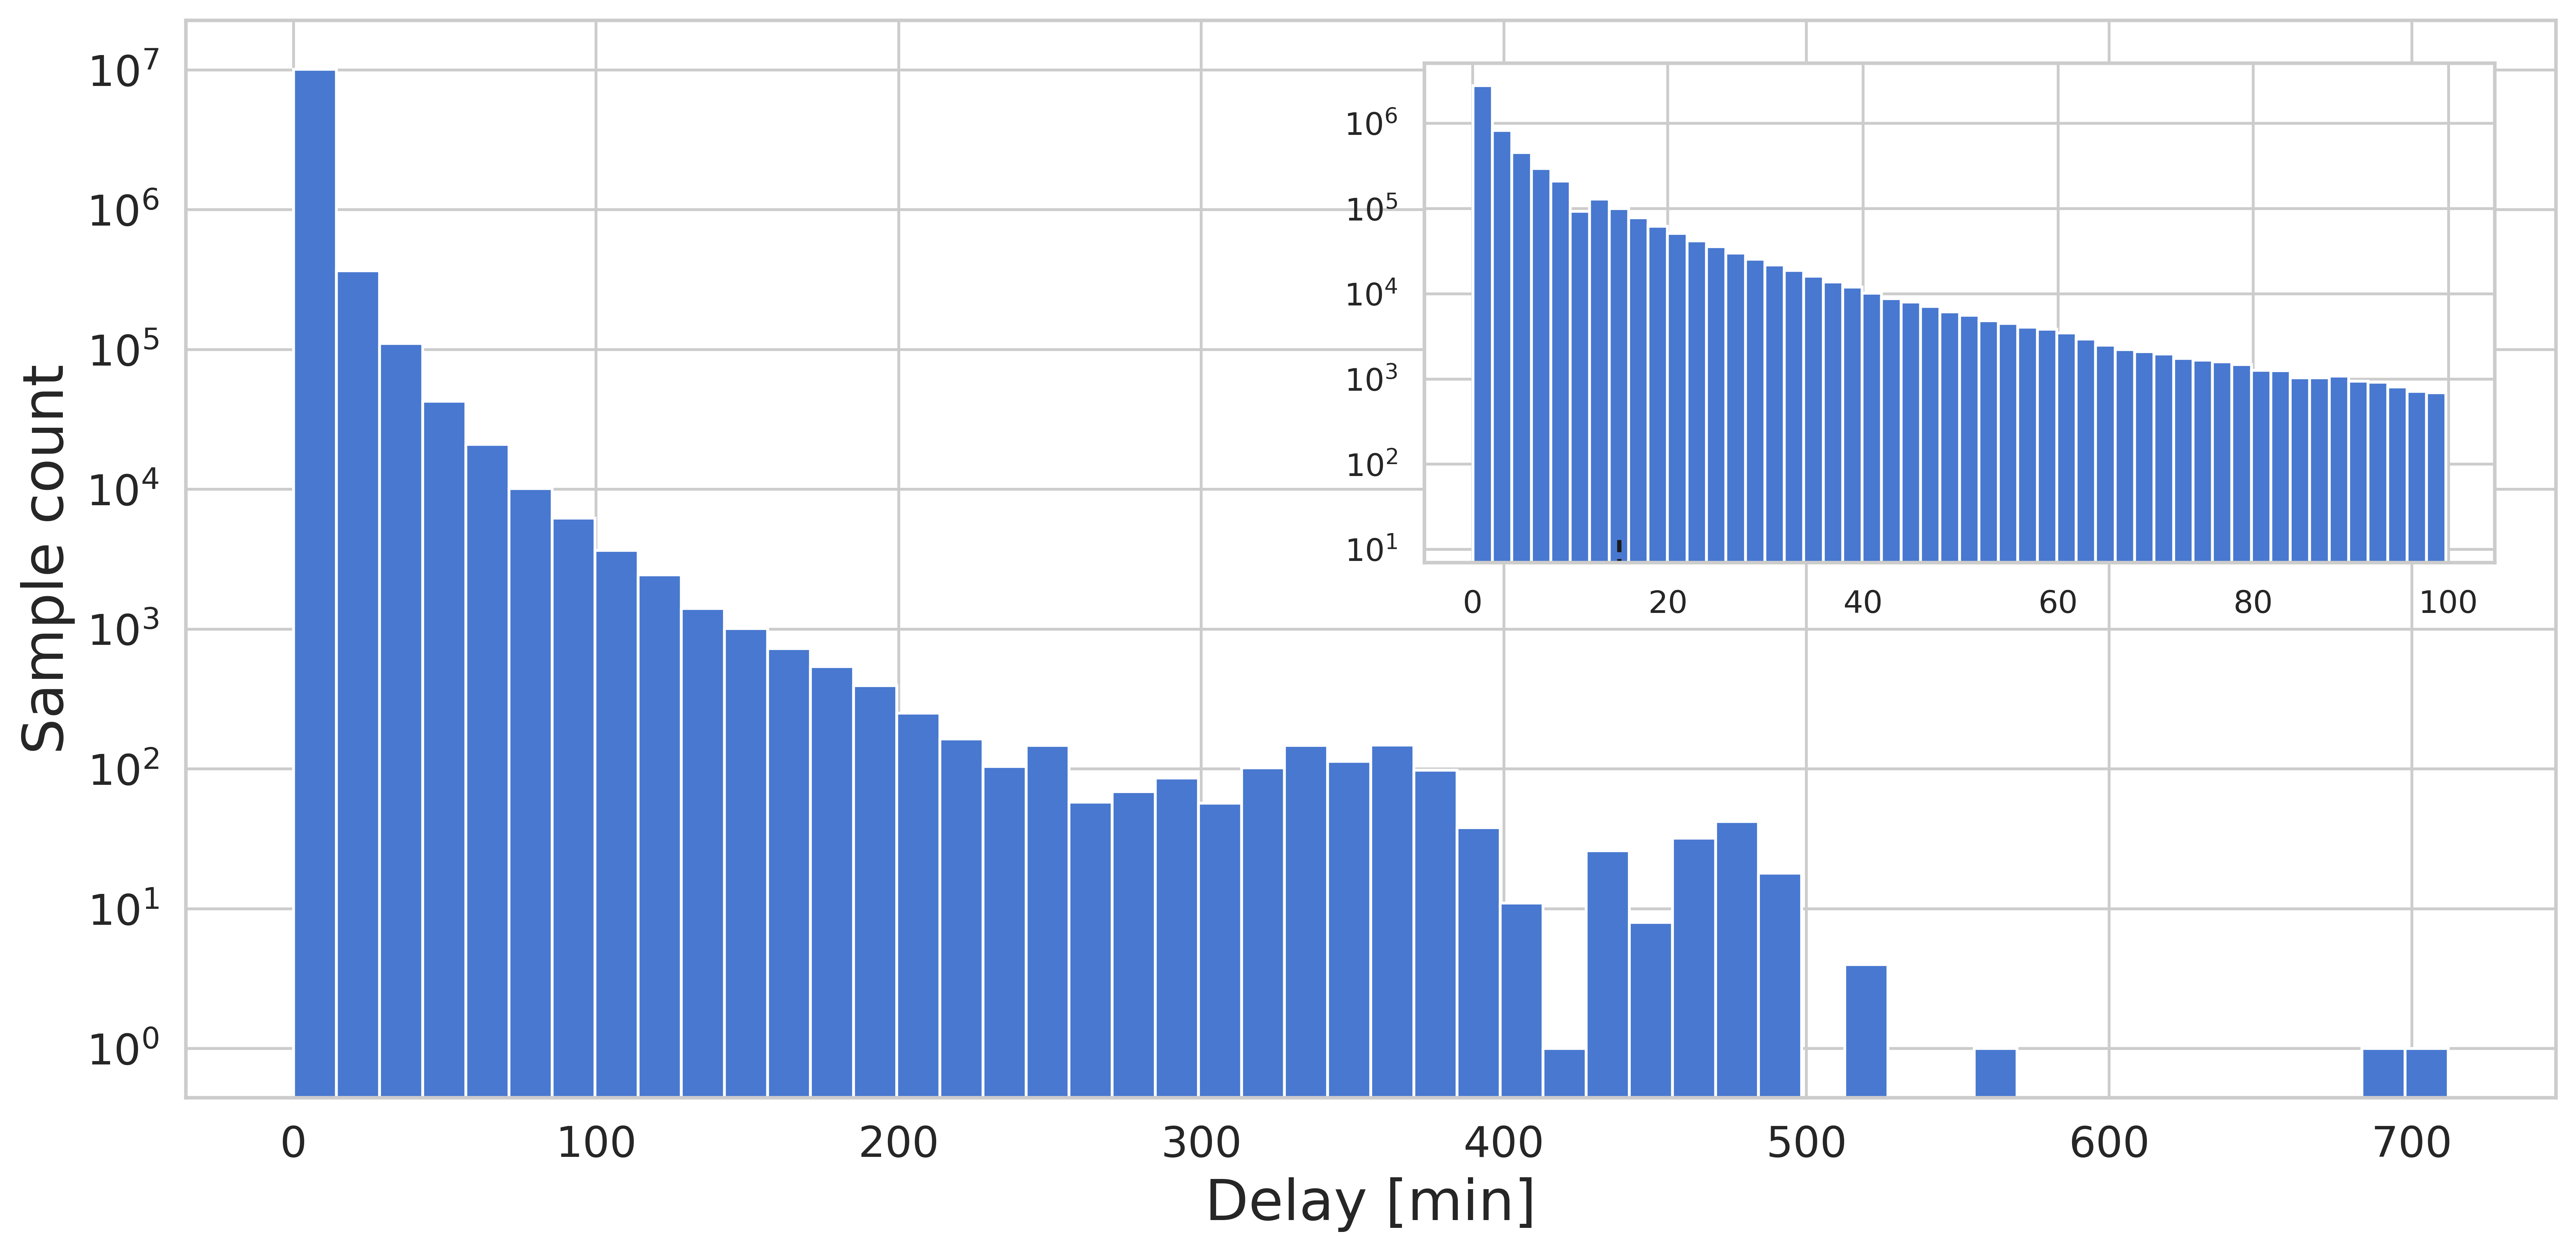

In [83]:
%matplotlib inline
fs=20
params = {'font.size': fs,
          'figure.dpi': 600}

plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(15,7))
ax.set_yscale('log')
avg_data.loc[:, 'delay'].hist(ax=ax,bins=50)

ax2 = fig.add_axes([0.53,0.5,0.35,0.35])
ax2.set_yscale('log')
ax2.hist(avg_data.loc[(avg_data['delay']>0) & (avg_data['delay'] < 100), 'delay'], bins=50)
ax2.vlines(15, 0, 10^7, linestyle='dashed')

ax.tick_params(axis = 'x', which = 'major', labelsize = 3/4*fs)
ax.tick_params(axis = 'y', which = 'major', labelsize = 3/4*fs)
ax.set_xlabel('Delay [min]', fontsize=fs)
ax.set_ylabel('Sample count', fontsize=fs)

#avg_data.loc[(avg_data['delay']>0) & (avg_data['delay'] < 30):, 'delay'].hist(ax=ax2,bins=50)


#avg_data.loc[:, 'delay'].hist(ax=ax, bins=50)

In [102]:
def print_stats(data):
    size = len(data)
    class_0_size = len(data.loc[(data['delay'] <= 10), :])
    class_1_size = len(data.loc[(data['delay'] > 10), :])
    class_1_ratio = len(data.loc[(data['delay'] > 10), :])/len(data)*100
    print(f'Dataset size: {size}')
    print(f'Class 0 size: {class_0_size}')
    print(f'Class 1 size: {class_1_size}')
    print(f'Class 1 ratio: {class_1_ratio:.2f} %')

print('Complete data \n---------------')
print_stats(avg_data)

print('\nWeather data \n---------------')
print_stats(avg_weather_data)

Complete data 
---------------
Dataset size: 10679977
Class 0 size: 9844073
Class 1 size: 835904
Class 1 ratio: 7.83 %

Weather data 
---------------
Dataset size: 7350
Class 0 size: 4889
Class 1 size: 2461
Class 1 ratio: 33.48 %


10636
Index(['EPO', 'HKH', 'HKI', 'HL', 'HPL', 'HY', 'ILA', 'ITA', 'JK', 'JP', 'KAN', 'KE', 'KEA', 'KIL', 'KLH', 'KNI', 'KRS', 'KVH', 'KVY', 'KYT', 'KÄP', 'LPV', 'LPÄ', 'ML', 'MYR', 'MÄK', 'OLK', 'PJM', 'PLA', 'PMK', 'PRL', 'PSL', 'PUR', 'RI', 'RKL', 'RY', 'SAU', 'SAV', 'TKL', 'TL', 'TNA', 'TPE', 'TU', 'VIA', 'VKS', 'VMO'], dtype='object', name='trainstation')


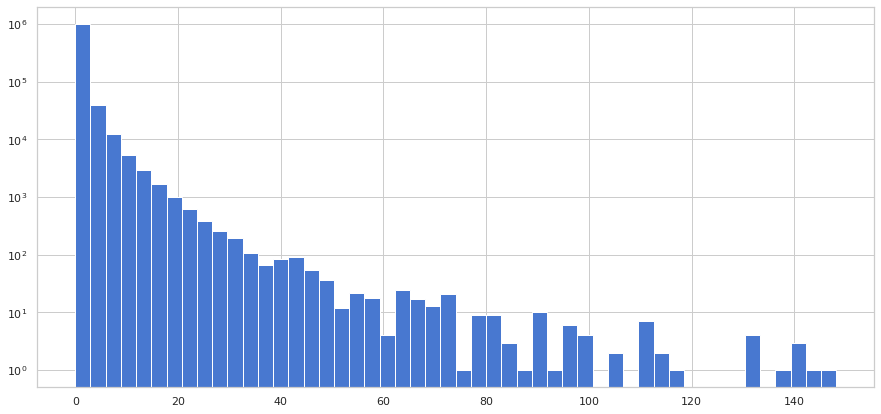

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_yscale('log')
avg_data.loc[(avg_data['train_count']>5), 'delay'].hist(ax=ax,bins=50)
print(len(avg_data.loc[(avg_data['train_count']>5) & (avg_data['delay'] > 10), 'delay']))
print(avg_data.loc[(avg_data['train_count']>5) & (avg_data['delay'] > 10), :].groupby(by='trainstation').count().index)

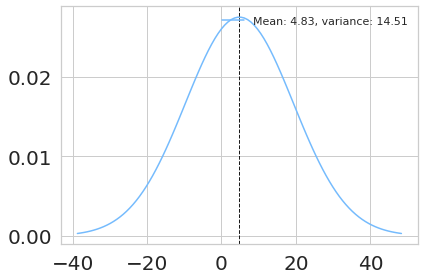

In [27]:
from scipy.stats import norm
colors = ['xkcd:sky blue', 'xkcd:tea', 'xkcd:dark orange', 'xkcd:purple grey']
fontsize=20

mean, std = norm.fit(all_data['delay'])

fig, ax = plt.subplots()
x = np.linspace(mean - 3*std, mean + 3*std, 100)

ax.plot(x, norm.pdf(x, mean, std), color=colors[0], label='Mean: {:.2f}, variance: {:.2f}'.format(mean, std))
ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = ax.get_ylim()
#ax.text(mu*1.1, max_ylim*.9-(.2*c), 'Mean: {:.2f}'.format(mu))

#ax.set_title(param, fontsize=fontsize)
ax.tick_params(axis = 'x', which = 'major', labelsize = fontsize)
ax.tick_params(axis = 'y', which = 'major', labelsize = fontsize)

ax.legend(loc='upper right')

plt.tight_layout()

In [34]:
print(all_data[(all_data['delay']>40)].shape[0]/all_data.shape[0])

0.02096689908601863


# Distance
https://nbviewer.jupyter.org/gist/urschrei/f76c6409e9b48e2d17402afaf64a313c

In [145]:
geodata = all_data.groupby(by='trainstation').max().loc[:, ['lat', 'lon']]

geodata['coords'] = list(zip(geodata.lat, geodata.lon))
print(geodata.head(2))
square = pd.DataFrame(
    np.zeros(len(geodata) ** 2).reshape(len(geodata), len(geodata)),
    index=geodata.index, columns=geodata.index)


print(square.head(2))
def get_distance(col):
    """
    This function looks up our 'end' coordinates from the df
    DataFrame using the input column name, then applies the
    geopy vincenty() function to each row in the input column,
    using the square.coords column as the first argument.
    This works because the function is applied column-wise from right to left.
    """
    end = geodata.loc[col.name, 'coords']
    return geodata['coords'].apply(geodesic, args=(end,))

distances = square.apply(get_distance, axis=1).T
print(distances.head(2))
def units(input_instance):
    return input_instance.meters

distances_meters = distances.applymap(units)
distances_meters.head()


                    lat        lon                  coords
trainstation                                              
AHV           61.291923  22.498185  (61.291923, 22.498185)
ALV           62.617769  23.600437  (62.617769, 23.600437)
trainstation  AHV  ALV  APT  ARL  ARO  DRA  ELA  ENO  EPO  ERV  ...  VTI  VUS  YLV  YLY  YLÖ  YPY   YV  ÄHT   ÄM   ÄS
trainstation                                                    ...                                                  
AHV           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
ALV           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[2 rows x 315 columns]
trainstation                    AHV                    ALV                    APT                    ARL                    ARO                    DRA                    ELA                    ENO                   EPO                    ERV  ...                   VTI

trainstation            AHV            ALV            APT            ARL            ARO            DRA            ELA            ENO            EPO            ERV  ...            VTI            VUS            YLV            YLY            YLÖ            YPY             YV            ÄHT             ÄM             ÄS
trainstation                                                                                                                                                        ...                                                                                                                                                      
AHV                0.000000  158670.895882  337186.876947  303552.579560  483514.407415  154831.190969  304398.900380  433684.175667  168842.437555  127555.921480  ...  377735.181463  523232.329729  126077.047547  399006.988158   65130.207767  501692.748055  326990.143870  162856.677600  514137.232651   11178.076004
ALV           158670.895882       0.000000  210268.273097  196539.696873  338190.136599  292861.969069  147207.054857  335238.426668  274698.278859  269805.823170  ...  219297.475174  380932.286207   40870.197669  306039.015330  118274.711459  358101.461396  168781.157750   24885.350050  363352.278804  154517.076293
APT           337186.876947  210268.273097       0.000000   53374.312916  157395.251639  417160.305351  186052.521286  139165.693997  366878.587688  404356.811344  ...  190025.871217  190650.458545  249810.296665  121728.363959  274413.985534  171567.000727  177353.814942  190790.644853  199279.512302  328512.432305
ARL           303552.579560  196539.696873   53374.312916       0.000000  208047.147501  370373.376703  211148.370957  138826.810862  317239.848919  359351.110862  ...  230409.868139  237777.406988  232658.558819  110003.822978  238951.752248  220425.196333  208312.284157  173671.193136  251577.893439  294034.631344
ARO           483514.407415  338190.136599  157395.251639  208047.147501       0.000000  573985.113424  244146.863830  191512.209130  524247.557426  560291.997801  ...  193843.033532   45588.192397  378979.588985  205787.647919  423902.219832   22009.415372  221275.951360  324981.124482   49042.150487  475923.376604

[5 rows x 315 columns]

In [8]:
bq.set_params(project=options.project,)
trains = bq.table_to_dataset('trains_delay','delay_all')

In [9]:
stations = bq.table_to_dataset('train_stations','FINstations')

In [13]:
trains = trains.loc[(trains['train_type'] == 'K'),:]

In [14]:
st = stations.set_index('stationShortCode')
trains_start = trains.join(st, on=['startstation'], how='left', rsuffix='_start')
trains_start.head(2)

total_delay  train_count train_type deststation  delay startstation                      time     type  stationUICCode passengerTraffic  longitude stationName   latitude countryCode
9504            0            1          K         KKN      0          STI 2011-11-09 12:00:00+00:00  STATION           576.0             True  24.221671     Siuntio  60.140648          FI
9505            0            1          K         KKN      0          STI 2014-03-02 18:00:00+00:00  STATION           576.0             True  24.221671     Siuntio  60.140648          FI

In [15]:
trains_end = trains_start.join(st, on=['deststation'], how='left', rsuffix='_end')
trains_end.head(2)

total_delay  train_count train_type deststation  delay startstation                      time     type  stationUICCode passengerTraffic  ...  stationName   latitude  countryCode type_end stationUICCode_end  passengerTraffic_end longitude_end  stationName_end latitude_end  countryCode_end
9504            0            1          K         KKN      0          STI 2011-11-09 12:00:00+00:00  STATION           576.0             True  ...      Siuntio  60.140648           FI  STATION               63.0                  True     24.438814      Kirkkonummi    60.119648               FI
9505            0            1          K         KKN      0          STI 2014-03-02 18:00:00+00:00  STATION           576.0             True  ...      Siuntio  60.140648           FI  STATION               63.0                  True     24.438814      Kirkkonummi    60.119648               FI

[2 rows x 21 columns]

In [16]:
trains_coords = trains_end.loc[:,['latitude', 'longitude', 'latitude_end', 'longitude_end']]
trains_coords['coords'] = list(zip(trains_end.loc[:,'latitude'], trains_end.loc[:, 'longitude']))

In [17]:
trains_coords.head(2)

latitude  longitude  latitude_end  longitude_end                  coords
9504  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)
9505  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)

In [18]:
trains_coords['coords_end'] = list(zip(trains_end.loc[:,'latitude_end'], trains_end.loc[:, 'longitude_end']))
trains_coords.head(2)

latitude  longitude  latitude_end  longitude_end                  coords              coords_end
9504  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)  (60.119648, 24.438814)
9505  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)  (60.119648, 24.438814)

In [19]:
def d(col):
    if np.isnan(col.latitude) or np.isnan(col.longitude) or np.isnan(col.latitude_end) or np.isnan(col.longitude_end):
        return None
    return geodesic(col.coords, col.coords_end)

col = trains_coords.iloc[1]
trains_coords['distance'] = trains_coords.apply(d, axis=1)

trains_coords.head(2)

latitude  longitude  latitude_end  longitude_end                  coords              coords_end               distance
9504  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)  (60.119648, 24.438814)  12.293648598222521 km
9505  60.140648  24.221671     60.119648      24.438814  (60.140648, 24.221671)  (60.119648, 24.438814)  12.293648598222521 km

In [21]:
trains_coords.sort_values(by='distance')

latitude  longitude  latitude_end  longitude_end                  coords              coords_end distance
11291546  65.028710  25.474942     65.028710      25.474942   (65.02871, 25.474942)   (65.02871, 25.474942)   0.0 km
15498114  60.221310  24.842976     60.221310      24.842976   (60.22131, 24.842976)   (60.22131, 24.842976)   0.0 km
4205281   60.207144  24.701273     60.207144      24.701273  (60.207144, 24.701273)  (60.207144, 24.701273)   0.0 km
1493706   60.229000  24.967676     60.229000      24.967676     (60.229, 24.967676)     (60.229, 24.967676)   0.0 km
5265125   62.110893  25.651352     62.110893      25.651352  (62.110893, 25.651352)  (62.110893, 25.651352)   0.0 km
...             ...        ...           ...            ...                     ...                     ...      ...
29079336        NaN        NaN     60.158661      24.539106              (nan, nan)  (60.158661, 24.539106)     None
29079506        NaN        NaN           NaN            NaN              (nan, nan)              (nan, nan)     None
29079583        NaN        NaN           NaN            NaN              (nan, nan)              (nan, nan)     None
29079591        NaN        NaN     60.189456      24.600354              (nan, nan)  (60.189456, 24.600354)     None
29079786  60.158661  24.539106           NaN            NaN  (60.158661, 24.539106)              (nan, nan)     None

[13666185 rows x 7 columns]

In [23]:
trains_coords.distance.max()

Distance(777.6964882219565)

In [25]:
print(len(trains_coords.loc[(trains_coords['distance']>100)]))
print(len(trains_coords))
print(len(trains_coords.loc[(trains_coords['distance']>100)])/len(trains_coords))

96201
13666185
0.007039345654987109


In [26]:
trains_coords.loc[(trains_coords['distance']>100),:]

latitude  longitude  latitude_end  longitude_end                  coords              coords_end               distance
9507      60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
9581      61.477212  21.786607     61.498236      23.773454  (61.477212, 21.786607)  (61.498236, 23.773454)  105.87288492334444 km
9583      60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
9584      60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
9585      60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
...             ...        ...           ...            ...                     ...                     ...                    ...
29208027  60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
29249706  62.174449  23.036413     60.198689      24.933521  (62.174449, 23.036413)  (60.198689, 24.933521)  242.63765209056456 km
29249784  62.512210  29.845911     60.198689      24.933521   (62.51221, 29.845911)  (60.198689, 24.933521)  367.97189714279193 km
29249785  60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km
29279803  60.450274  22.297114     60.198689      24.933521  (60.450274, 22.297114)  (60.198689, 24.933521)  148.33032266605107 km

[96201 rows x 7 columns]

In [27]:
trains.loc[(trains_coords['distance']>100),:]

total_delay  train_count train_type deststation  delay startstation                      time
9507                0            1          K         PSL      0          KUT 2011-03-08 19:00:00+00:00
9581                0            1          K         TPE      0          PRI 2011-08-17 12:00:00+00:00
9583                0            1          K         PSL      0          KUT 2011-07-30 06:00:00+00:00
9584                0            1          K         PSL      0          KUT 2011-02-12 18:00:00+00:00
9585                0            1          K         PSL      0          KUT 2011-08-19 06:00:00+00:00
...               ...          ...        ...         ...    ...          ...                       ...
29208027            0            1          K         PSL      0          KUT 2011-08-21 18:00:00+00:00
29249706            1            1          K         PSL      0          KIS 2012-07-18 19:00:00+00:00
29249784            0            1          K         PSL      0          NTH 2013-12-11 08:00:00+00:00
29249785            0            1          K         PSL      0          KUT 2011-04-22 17:00:00+00:00
29279803            0            1          K         PSL      0          KUT 2011-07-08 18:00:00+00:00

[96201 rows x 7 columns]

In [32]:
trains.loc[(trains_coords['distance']>100) & (trains['startstation'] == 'PSL') & (trains['deststation'] == 'TPE'),:]

total_delay  train_count train_type deststation  delay startstation                      time
4117236            0            1          K         TPE     32          PSL 2010-01-04 23:00:00+00:00